In [1]:
import ast
import pandas as pd
import numpy as np
import string
import random

pd.set_option('display.max_columns', 150)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt

In [3]:
# fetch all tables from csv files
artists_lyrics = pd.read_csv("complete-artists-lyrics.csv")
genre_df = pd.read_csv("genre-list.csv")
genre_matrix = pd.read_csv("all-genre-words.csv")

In [4]:
def declutter_csv(tbl):
    tbl.drop(['Unnamed: 0'], axis=1, inplace=True)
declutter_csv(artists_lyrics)
declutter_csv(genre_df)

In [5]:
%%time

# realized i don't need this anymore
artists_lyrics.drop(['Set'], axis=1, inplace=True)

for i in range(artists_lyrics.shape[0]):
    artists_lyrics["Genres"][i] = ast.literal_eval(artists_lyrics["Genres"][i])
artists_lyrics.reset_index(drop=True, inplace=True)

artists_lyrics

Wall time: 11.2 s


,Artist,Genres,Link,SLink,Lyric
0,Wolf Alice,"[Rock, Indie]",/wolf-alice/,/wolf-alice/bros.html,shake your hair have some fun forget our mothe...
1,Marié Digby,"[Pop, Romantic, Pop]",/marie-digby/,/marie-digby/you-give-me-something.html,you only stay with me in the morning you only ...
2,Boyce Avenue,"[Pop, Romantic]",/boyce-avenue/,/boyce-avenue/send-my-love-to-your-new-lover.html,"this was all you, none of it me you put your h..."
3,Smash Mouth,"[Rock, Rock]",/smash-mouth/,/smash-mouth/i-wanna-be-like-you.html,can you hear it? yeah man now i'm the king of ...
4,Dawes,"[Folk, Indie, Rock]",/dawes/,/dawes/when-you-call-my-name.html,if all my lovers sing the big words and all my...
...,...,...,...,...,...
46545,James Arthur,"[Pop, Soul]",/james-arthur/,/james-arthur/prisoner.html,if i'm underneath the table then pour me anoth...
46546,Barry Manilow,[Romantic],/barry-manilow/,/barry-manilow/we-wish-you-a-merry-christmas.html,we wish you a merry christmas we wish you a me...
46547,Wanessa Camargo,"[Dance, Romantic, Pop]",/wanessa-camargo/,/wanessa-camargo/get-loudi.html,get it right! we'll party until the morning li...
46548,Tony Bennett & Lady Gaga,[Jazz],/tony-bennett-lady-gaga/,/tony-bennett-lady-gaga/they-all-laughed.html,they all laughed at christopher columbus when ...


In [6]:
remove_columns = genre_df[genre_df['Count'] <= 20]["Genre"]
remove_columns.values

array(['Trip-Hop', 'Punk', 'Trance', 'Chillout', 'Ska', 'Reggaeton',
       'Industrial', 'Classic Rock', 'Metal', 'Lo-fi', 'Post-Rock',
       'Tropical House', 'World Music', 'Black Music'], dtype=object)

In [7]:
genre_df = genre_df[genre_df['Count'] > 20]
genre_df

,Count,Genre
0,1201,Rock
1,596,Pop
2,254,Indie
3,203,Heavy Metal
4,202,Hip Hop
5,193,Romantic
6,180,Dance
7,164,Electronica
8,149,Rap
9,144,R&B


In [8]:
genre_matrix = genre_matrix.fillna(0)
genre_matrix.rename(columns={"Unnamed: 0":"ENTRY"}, inplace=True)
# remove genres from genre_mat
for i in range(len(remove_columns.values)):
    if remove_columns.values[i] in genre_matrix.columns.values:
        genre_matrix.drop(columns=[remove_columns.values[i]], inplace=True)
genre_matrix

,ENTRY,Rock,Indie,Pop,Romantic,Folk,Grunge,Jazz,Classic,New Wave,Rap,Hip Hop,Heavy Metal,Country,Hardcore,Rockabilly,Blues,R&B,Soul,Dance,Gospel,Funk,Emocore,Psychedelic music,House,Electronica,Progressive Music,Disco,Soundtack,Reggae,Surf Music,Children's music,Instrumental
0,shake,1528.0,189.0,1568.0,257.0,94.0,21.0,35.0,4.0,11.0,726.0,879.0,133.0,75.0,120.0,105.0,164.0,564.0,148.0,347.0,109.0,122.0,10.0,28.0,42.0,290.0,19.0,116.0,167.0,56.0,7.0,38.0,2.0
1,hair,1117.0,247.0,808.0,233.0,177.0,17.0,40.0,7.0,26.0,287.0,308.0,122.0,157.0,47.0,40.0,113.0,217.0,80.0,156.0,20.0,29.0,12.0,63.0,13.0,64.0,30.0,24.0,107.0,9.0,30.0,7.0,7.0
2,fun,1540.0,259.0,976.0,190.0,89.0,24.0,66.0,11.0,34.0,279.0,311.0,138.0,109.0,97.0,63.0,93.0,288.0,115.0,347.0,22.0,54.0,5.0,27.0,45.0,147.0,21.0,37.0,130.0,54.0,25.0,55.0,8.0
3,forget,2453.0,372.0,1508.0,485.0,218.0,75.0,115.0,54.0,33.0,436.0,531.0,349.0,186.0,158.0,65.0,97.0,401.0,157.0,406.0,75.0,33.0,74.0,38.0,17.0,128.0,49.0,57.0,107.0,53.0,38.0,4.0,14.0
4,mothers,289.0,55.0,102.0,43.0,54.0,5.0,13.0,4.0,10.0,78.0,81.0,49.0,35.0,11.0,1.0,10.0,37.0,21.0,24.0,12.0,5.0,0.0,10.0,1.0,7.0,11.0,11.0,10.0,7.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39066,repulsively,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39067,creature’s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39068,investigative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39069,wallabies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [9]:
artists_lyrics['Genres'] = artists_lyrics['Genres'].apply(lambda x: [i.lstrip().strip() for i in x if i not in remove_columns.values])
artists_lyrics

,Artist,Genres,Link,SLink,Lyric
0,Wolf Alice,"[Rock, Indie]",/wolf-alice/,/wolf-alice/bros.html,shake your hair have some fun forget our mothe...
1,Marié Digby,"[Pop, Romantic, Pop]",/marie-digby/,/marie-digby/you-give-me-something.html,you only stay with me in the morning you only ...
2,Boyce Avenue,"[Pop, Romantic]",/boyce-avenue/,/boyce-avenue/send-my-love-to-your-new-lover.html,"this was all you, none of it me you put your h..."
3,Smash Mouth,"[Rock, Rock]",/smash-mouth/,/smash-mouth/i-wanna-be-like-you.html,can you hear it? yeah man now i'm the king of ...
4,Dawes,"[Folk, Indie, Rock]",/dawes/,/dawes/when-you-call-my-name.html,if all my lovers sing the big words and all my...
...,...,...,...,...,...
46545,James Arthur,"[Pop, Soul]",/james-arthur/,/james-arthur/prisoner.html,if i'm underneath the table then pour me anoth...
46546,Barry Manilow,[Romantic],/barry-manilow/,/barry-manilow/we-wish-you-a-merry-christmas.html,we wish you a merry christmas we wish you a me...
46547,Wanessa Camargo,"[Dance, Romantic, Pop]",/wanessa-camargo/,/wanessa-camargo/get-loudi.html,get it right! we'll party until the morning li...
46548,Tony Bennett & Lady Gaga,[Jazz],/tony-bennett-lady-gaga/,/tony-bennett-lady-gaga/they-all-laughed.html,they all laughed at christopher columbus when ...


In [10]:
#####
# let's quickly label each genre by number AND only pick one genre for simplicity

In [11]:
%%time

artists_lyrics['First Genre'] = ""
artists_lyrics['Second Genre'] = ""
for i in range(artists_lyrics.shape[0]):
    try:
        artists_lyrics["First Genre"].iloc[i] = artists_lyrics["Genres"].iloc[i][0]
        artists_lyrics["Second Genre"].iloc[i] = artists_lyrics["Genres"].iloc[i][1 if len(artists_lyrics["Genres"].iloc[i]) > 1 else 0] 
    except IndexError:
        artists_lyrics.drop([i], inplace=True)
        continue
    except KeyError:
        artists_lyrics.drop([i], inplace=True)
        continue
artists_lyrics.drop(["Genres"], axis=1, inplace=True)
artists_lyrics.reset_index(drop=True, inplace=True)
artists_lyrics

Wall time: 44.4 s


,Artist,Link,SLink,Lyric,First Genre,Second Genre
0,Wolf Alice,/wolf-alice/,/wolf-alice/bros.html,shake your hair have some fun forget our mothe...,Rock,Indie
1,Marié Digby,/marie-digby/,/marie-digby/you-give-me-something.html,you only stay with me in the morning you only ...,Pop,Romantic
2,Boyce Avenue,/boyce-avenue/,/boyce-avenue/send-my-love-to-your-new-lover.html,"this was all you, none of it me you put your h...",Pop,Romantic
3,Smash Mouth,/smash-mouth/,/smash-mouth/i-wanna-be-like-you.html,can you hear it? yeah man now i'm the king of ...,Rock,Rock
4,Dawes,/dawes/,/dawes/when-you-call-my-name.html,if all my lovers sing the big words and all my...,Folk,Indie
...,...,...,...,...,...,...
46139,Depeche Mode,/depeche-mode/,/depeche-mode/now-this-is-fun.html,here speaks the voice of reason it's talking t...,New Wave,Pop
46140,Diana Ross,/diana-ross/,/diana-ross/stay-with-me.html,stay with me spend just one more day with me m...,R&B,Soul
46141,Rolling Stones,/the-rolling-stones/,/the-rolling-stones/shes-so-cold.html,"i'm so hot for her, i'm so hot for her i'm so ...",Rock,Blues
46142,Staind,/staind/,/staind/open-your-eyes.html,as i walk along these streets i see a man that...,Rock,Rock


In [12]:
artists_lyrics = artists_lyrics[artists_lyrics['First Genre'] != '']
artists_lyrics = artists_lyrics[artists_lyrics['Second Genre'] != '']
artists_lyrics.reset_index(drop=True, inplace=True)
artists_lyrics

,Artist,Link,SLink,Lyric,First Genre,Second Genre
0,Wolf Alice,/wolf-alice/,/wolf-alice/bros.html,shake your hair have some fun forget our mothe...,Rock,Indie
1,Marié Digby,/marie-digby/,/marie-digby/you-give-me-something.html,you only stay with me in the morning you only ...,Pop,Romantic
2,Boyce Avenue,/boyce-avenue/,/boyce-avenue/send-my-love-to-your-new-lover.html,"this was all you, none of it me you put your h...",Pop,Romantic
3,Smash Mouth,/smash-mouth/,/smash-mouth/i-wanna-be-like-you.html,can you hear it? yeah man now i'm the king of ...,Rock,Rock
4,Dawes,/dawes/,/dawes/when-you-call-my-name.html,if all my lovers sing the big words and all my...,Folk,Indie
...,...,...,...,...,...,...
45737,Depeche Mode,/depeche-mode/,/depeche-mode/now-this-is-fun.html,here speaks the voice of reason it's talking t...,New Wave,Pop
45738,Diana Ross,/diana-ross/,/diana-ross/stay-with-me.html,stay with me spend just one more day with me m...,R&B,Soul
45739,Rolling Stones,/the-rolling-stones/,/the-rolling-stones/shes-so-cold.html,"i'm so hot for her, i'm so hot for her i'm so ...",Rock,Blues
45740,Staind,/staind/,/staind/open-your-eyes.html,as i walk along these streets i see a man that...,Rock,Rock


In [13]:
# one more finishing touch
artists_lyrics.drop(columns=['Artist', 'Link', 'SLink'], inplace=True)
artists_lyrics = shuffle(artists_lyrics)
artists_lyrics.reset_index(drop=True, inplace=True)

# refer to the genre_df table from now on, until the end...

In [14]:
artists_lyrics = artists_lyrics[pd.notnull(artists_lyrics['Lyric'])]
artists_lyrics.reset_index(drop=True, inplace=True)
artists_lyrics

,Lyric,First Genre,Second Genre
0,shortcut to part of joan baez lyrics joan baez...,Folk,Psychedelic music
1,maceo parker: (i am maceo. i be blowin' the so...,Rap,Rap
2,i met a girl who hated the world she used her ...,Rock,Rock
3,"but all i know, is all i know is the disco inf...",Indie,Electronica
4,meet me here beneath the burning skies where t...,Rock,Rock
...,...,...,...
42513,i got me a woman she's just my height and size...,Indie,Rock
42514,it's amazing how you can speak right to my hea...,Country,Romantic
42515,that look on your face you’re breathing at nig...,Dance,Electronica
42516,"listen or fuck yourselves, don't be assholes t...",Heavy Metal,Rock


In [15]:
artists_lyrics.to_csv("final-artists-lyrics.csv")

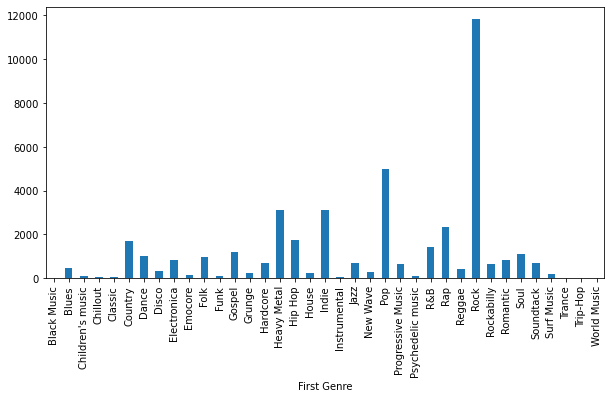

In [16]:
fig = plt.figure(figsize=(10,5))
artists_lyrics.groupby('First Genre').Lyric.count().plot.bar(ylim=0)
plt.show()

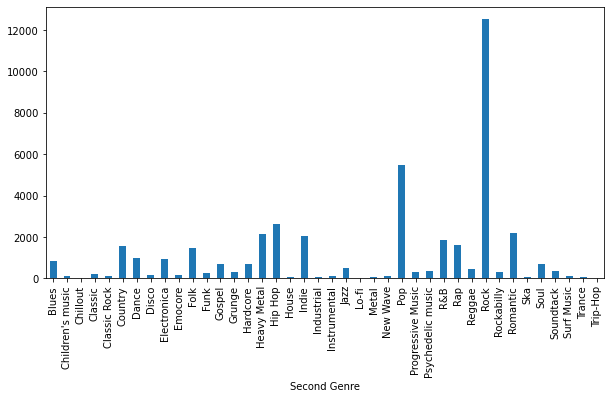

In [17]:
fig = plt.figure(figsize=(10,5))
artists_lyrics.groupby('Second Genre').Lyric.count().plot.bar(ylim=0)
plt.show()

In [18]:
artists_lyrics

,Lyric,First Genre,Second Genre
0,shortcut to part of joan baez lyrics joan baez...,Folk,Psychedelic music
1,maceo parker: (i am maceo. i be blowin' the so...,Rap,Rap
2,i met a girl who hated the world she used her ...,Rock,Rock
3,"but all i know, is all i know is the disco inf...",Indie,Electronica
4,meet me here beneath the burning skies where t...,Rock,Rock
...,...,...,...
42513,i got me a woman she's just my height and size...,Indie,Rock
42514,it's amazing how you can speak right to my hea...,Country,Romantic
42515,that look on your face you’re breathing at nig...,Dance,Electronica
42516,"listen or fuck yourselves, don't be assholes t...",Heavy Metal,Rock


In [19]:
artists_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42518 entries, 0 to 42517
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Lyric         42518 non-null  object
 1   First Genre   42518 non-null  object
 2   Second Genre  42518 non-null  object
dtypes: object(3)
memory usage: 996.6+ KB


In [20]:
# new_artists_lyrics = artists_lyrics[0 : int(artists_lyrics.shape[0] * 0.25) : 1]

new_artists_lyrics = artists_lyrics
new_artists_lyrics = shuffle(new_artists_lyrics)
new_artists_lyrics.reset_index(drop=True, inplace=True)
new_artists_lyrics

,Lyric,First Genre,Second Genre
0,"producing... from listening to records, i just...",Electronica,Hip Hop
1,since you've been gone it's been raining hard ...,New Wave,Pop
2,"marvo ging, marvo ging, boy i love your specia...",Electronica,Electronica
3,you're too important for anyone you play the r...,Rock,Rock
4,booker t's at the front door saying it's time ...,Disco,R&B
...,...,...,...
42513,sitting with the bible in my grasp and a gun i...,Rock,Hardcore
42514,the day we met i knew i.. need you so and if i...,Rock,Rock
42515,"i found a love for me oh, darling just dive ri...",Pop,R&B
42516,we skipped the light fandango and turned cartw...,Heavy Metal,Heavy Metal


In [21]:
last_time_filtering = new_artists_lyrics['First Genre'].value_counts()[new_artists_lyrics['First Genre'].value_counts() < 50].index.tolist()
last_time_filtering

['Trance', 'Trip-Hop', 'Black Music', 'World Music']

In [22]:
new_artists_lyrics = new_artists_lyrics[~new_artists_lyrics['First Genre'].isin(last_time_filtering)]
new_artists_lyrics = new_artists_lyrics[~new_artists_lyrics['Second Genre'].isin(last_time_filtering)]

new_artists_lyrics = shuffle(new_artists_lyrics[0:10000])
new_artists_lyrics.reset_index(drop=True, inplace=True)
new_artists_lyrics

,Lyric,First Genre,Second Genre
0,force fed more than we eat in the wild raised ...,Rock,Heavy Metal
1,"you were the flame, but you burned out easily ...",Hardcore,Emocore
2,"everybody's hearing the new sound, old shcool ...",Indie,Folk
3,"i came to you, when i needed a rest you took m...",Rock,Folk
4,every second's soaked in sadness every weekend...,Rock,Hardcore
...,...,...,...
9995,"chloe, chloe, someone's callin, no reply. nigh...",Jazz,Jazz
9996,take my time. take it easier. don't need no li...,Electronica,Pop
9997,"kill me, it takes a lot to kill me. flashback,...",R&B,Pop
9998,oh she dressed in the dark and she whispered a...,Rock,Folk


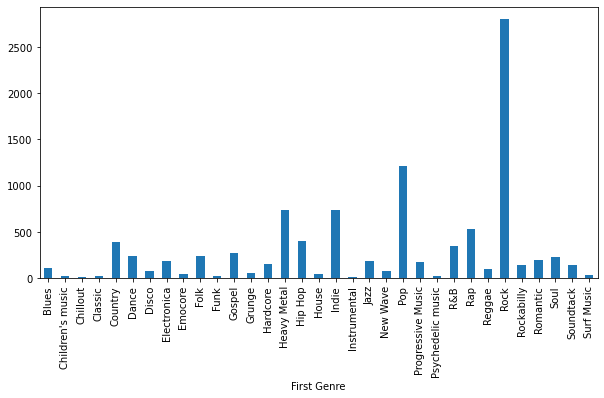

In [23]:
fig = plt.figure(figsize=(10,5))
new_artists_lyrics.groupby('First Genre').Lyric.count().plot.bar(ylim=0)
plt.show()

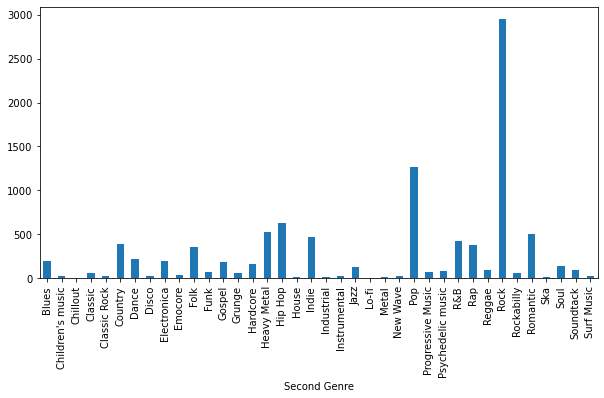

In [24]:
fig = plt.figure(figsize=(10,5))
new_artists_lyrics.groupby('Second Genre').Lyric.count().plot.bar(ylim=0)
plt.show()

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

<h5>Works in progress...</h5>

In [26]:
al_one = new_artists_lyrics.drop(['Second Genre'], axis=1)
y = al_one['First Genre'].tolist()
al_train, al_test = train_test_split(al_one, test_size=0.18, random_state=0, stratify=y)

In [27]:
first_features = al_train['First Genre'].unique().tolist()
first_features

['Indie',
 'Romantic',
 'R&B',
 'Jazz',
 'Heavy Metal',
 'New Wave',
 'Rap',
 'Disco',
 'Progressive Music',
 'Country',
 'Reggae',
 'Dance',
 'Folk',
 'Rock',
 'Gospel',
 'Classic',
 'Pop',
 'Hip Hop',
 'Electronica',
 'Hardcore',
 'Psychedelic music',
 'Soundtack',
 'Soul',
 'House',
 'Blues',
 'Surf Music',
 'Grunge',
 'Funk',
 'Rockabilly',
 "Children's music",
 'Instrumental',
 'Emocore',
 'Chillout']

In [28]:
al_train

,Lyric,First Genre
4725,morning prayers took the girl unawares she was...,Indie
4673,i get so high (feat. method man & redman) [red...,Romantic
74,they'll be no darkness tonight baby our love w...,R&B
8931,when i try to sing you say i'm off key why can...,Jazz
4332,live in darkest dreams; drugs roam in my head ...,Heavy Metal
...,...,...
5555,if i gotta stay in one world im gonna pick th...,Indie
2861,"oh my god, tell me this won't last forever tel...",Rock
5337,i've met many people over the years and in my ...,Funk
6857,it was way too hard it was way too tough on th...,Rock


In [29]:
al_test.shape

(1800, 2)

In [30]:
tfidf = TfidfVectorizer(stop_words='english')
al_train_vectors = tfidf.fit_transform(al_train['Lyric'])
al_test_vectors = tfidf.transform(al_test['Lyric'])
print(al_train_vectors.shape)
print(al_test_vectors.shape)

(8200, 34994)
(1800, 34994)


In [31]:
raise Exception

Exception: 

<br>
<b>The next few cells will take a while...</b>

In [32]:
%%time

Xtr_one = al_train_vectors
Ytr_one = al_train['First Genre']

Xte_one = al_test_vectors
Yte_one = al_test['First Genre']

k_range = range(1,5)
param_grid = dict(n_neighbors=k_range)
clf_knn = KNeighborsClassifier(n_neighbors=1)

gridcv = GridSearchCV(clf_knn, param_grid, cv=5, scoring='accuracy')
gridcv.fit(Xtr_one, Ytr_one)

print(gridcv.best_score_)
print(gridcv.best_params_)

0.18073170731707316
{'n_neighbors': 4}
Wall time: 10.8 s


In [33]:
%%time

log_coeff = range(1,10)
log_param_grid = dict(C=log_coeff)

log_clf = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=2)

log_grid = GridSearchCV(log_clf, log_param_grid, cv=5, scoring='accuracy')
log_grid.fit(Xtr_one, Ytr_one)

print(log_grid.best_params_)

new_log_clf = LogisticRegression(penalty='l2', C=log_grid.best_params_['C'], max_iter=1000, n_jobs=2)
new_log_clf.fit(Xtr_one, Ytr_one)

new_y_pred_one = new_log_clf.predict(Xte_one)

acc = accuracy_score(Yte_one, new_y_pred_one)
macro_f1 = f1_score(Yte_one, new_y_pred_one, average='macro')
micro_f1 = f1_score(Yte_one, new_y_pred_one, average='micro')

print(acc, macro_f1, micro_f1)

{'C': 3}
0.35555555555555557 0.11614313256404439 0.35555555555555557
Wall time: 39min 44s


In [34]:
%%time

log_clf_kmeans = KMeans(n_clusters=len(first_features))
log_clf_kmeans = log_clf_kmeans.fit(Xtr_one)
terms = tfidf.get_feature_names()
centers = log_clf_kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(len(first_features)):
    print(f"Cluster {i}")
    for c in centers[i, 0:10]:
        print(f'\t{terms[c]}')

Cluster 0
	away
	far
	don
	fly
	day
	just
	ll
	run
	sail
	love
Cluster 1
	little
	da
	bit
	just
	love
	oh
	baby
	tell
	don
	like
Cluster 2
	time
	say
	goodbye
	way
	tell
	just
	love
	don
	day
	long
Cluster 3
	love
	need
	know
	heart
	just
	don
	time
	ll
	say
	ve
Cluster 4
	life
	eyes
	world
	heart
	love
	day
	lost
	inside
	know
	pain
Cluster 5
	home
	coming
	come
	just
	gone
	know
	ve
	don
	like
	ll
Cluster 6
	don
	know
	just
	say
	need
	love
	like
	cause
	tell
	ve
Cluster 7
	oh
	yeah
	love
	don
	baby
	know
	just
	make
	come
	ll
Cluster 8
	yeah
	oh
	know
	got
	love
	don
	baby
	ll
	ve
	like
Cluster 9
	ve
	got
	know
	just
	love
	don
	life
	ll
	way
	time
Cluster 10
	christmas
	merry
	year
	love
	santa
	time
	tree
	blue
	mistletoe
	bells
Cluster 11
	got
	ain
	like
	rock
	man
	just
	don
	know
	uh
	roll
Cluster 12
	girl
	know
	like
	got
	don
	love
	man
	just
	baby
	world
Cluster 13
	nigga
	shit
	niggas
	like
	fuck
	ain
	bitch
	niggaz
	got
	em
Cluster 14
	right
	thing
	just
	know
	time
	cause

In [35]:
raise Exception

Exception: 

In [36]:
al_two = new_artists_lyrics.drop(['First Genre'], axis=1)
y = al_two['Second Genre'].tolist()
al_train, al_test = train_test_split(al_two, test_size=0.18, random_state=0, stratify=y)

In [37]:
second_features = al_train['Second Genre'].unique().tolist()
second_features

['Hip Hop',
 'Funk',
 'Rock',
 'Psychedelic music',
 'Folk',
 'Indie',
 'Electronica',
 'Metal',
 'Romantic',
 'Pop',
 'R&B',
 'Blues',
 'Heavy Metal',
 'Rap',
 'Soul',
 'Hardcore',
 'Classic',
 'Disco',
 "Children's music",
 'Gospel',
 'Jazz',
 'Dance',
 'Country',
 'Rockabilly',
 'Reggae',
 'Progressive Music',
 'Industrial',
 'Soundtack',
 'Grunge',
 'Instrumental',
 'Surf Music',
 'Ska',
 'Emocore',
 'New Wave',
 'Classic Rock',
 'House',
 'Chillout',
 'Lo-fi']

In [38]:
al_train

,Lyric,Second Genre
5020,"boo, boo ooh, ooh (ooh, dj montay) (ooh, [?] t...",Hip Hop
3308,some people say you gotta fight for a love tha...,Funk
9007,this is total junk and the opposite of what i ...,Rock
8011,what is this that stands before me figure in b...,Rock
6410,"amen, amen, amen, amen, amen sing it over amen...",Psychedelic music
...,...,...
4345,"diamonds and dust poor man last, rich man firs...",Rock
7290,"(erick sermon) what's up wit that homegirl, wh...",Hip Hop
7328,"if i miss my chance, i didn't even try i'm not...",Folk
5348,"you won't find me, knockin' at your door. i've...",Rock


In [39]:
al_test.shape

(1800, 2)

In [40]:
tfidf = TfidfVectorizer(stop_words='english')
al_train_vectors = tfidf.fit_transform(al_train['Lyric'])
al_test_vectors = tfidf.transform(al_test['Lyric'])
print(al_train_vectors.shape)
print(al_test_vectors.shape)

(8200, 34796)
(1800, 34796)


In [41]:
%%time

Xtr_two = al_train_vectors
Ytr_two = al_train['Second Genre']

Xte_two = al_test_vectors
Yte_two = al_test['Second Genre']

k_range = range(1,5)
param_grid = dict(n_neighbors=k_range)
clf_knn = KNeighborsClassifier(n_neighbors=1)

gridcv = GridSearchCV(clf_knn, param_grid, cv=5, scoring='accuracy')
gridcv.fit(Xtr_two, Ytr_two)

print(gridcv.best_score_)
print(gridcv.best_params_)

C:\Users\shull\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.175
{'n_neighbors': 4}
Wall time: 11.3 s


In [42]:
%%time

log_coeff = range(1,10)
log_param_grid = dict(C=log_coeff)

log_clf = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=2)

log_grid = GridSearchCV(log_clf, log_param_grid, cv=5, scoring='accuracy')
log_grid.fit(Xtr_two, Ytr_two)

print(log_grid.best_params_)

new_log_clf = LogisticRegression(penalty='l2', C=log_grid.best_params_['C'], max_iter=1000, n_jobs=2)
new_log_clf.fit(Xtr_two, Ytr_two)

new_y_pred_two = new_log_clf.predict(Xte_two)

acc = accuracy_score(Yte_two, new_y_pred_two)
macro_f1 = f1_score(Yte_two, new_y_pred_two, average='macro')
micro_f1 = f1_score(Yte_two, new_y_pred_two, average='micro')

print(acc, macro_f1, micro_f1)

C:\Users\shull\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 2}
0.3522222222222222 0.0679471926576408 0.3522222222222222
Wall time: 50min 6s


In [43]:
%%time

log_clf_kmeans = KMeans(n_clusters=len(second_features))
log_clf_kmeans = log_clf_kmeans.fit(Xtr_two)
terms = tfidf.get_feature_names()
centers = log_clf_kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(len(first_features)):
    print(f"Cluster {i}")
    for c in centers[i, 0:10]:
        print(f'\t{terms[c]}')

Cluster 0
	ll
	love
	just
	know
	away
	need
	alright
	come
	way
	make
Cluster 1
	hey
	don
	like
	love
	got
	oh
	know
	just
	make
	girl
Cluster 2
	yeah
	oh
	got
	know
	love
	don
	baby
	ll
	like
	just
Cluster 3
	like
	man
	just
	don
	know
	love
	ll
	got
	oh
	little
Cluster 4
	day
	away
	just
	long
	love
	night
	today
	ll
	come
	don
Cluster 5
	sing
	sweet
	song
	thing
	love
	dream
	oh
	just
	ll
	come
Cluster 6
	talk
	don
	step
	like
	say
	know
	just
	need
	way
	love
Cluster 7
	ooh
	oh
	yeah
	love
	like
	don
	know
	feeling
	just
	baby
Cluster 8
	girl
	know
	like
	got
	oh
	just
	love
	don
	baby
	ll
Cluster 9
	la
	love
	da
	oh
	come
	don
	baby
	fa
	tomorrow
	know
Cluster 10
	na
	oh
	know
	ve
	ba
	ll
	grind
	better
	make
	just
Cluster 11
	oh
	love
	yeah
	don
	baby
	know
	just
	got
	like
	make
Cluster 12
	lost
	carry
	wanted
	ve
	life
	know
	love
	oh
	just
	long
Cluster 13
	home
	gone
	coming
	come
	ve
	away
	long
	just
	know
	love
Cluster 14
	dance
	let
	music
	wanna
	just
	baby
	like
	night


In [ ]:
# https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640
# https://github.com/Idilismiguzel/NLP-with-Python/blob/master/Text-Classification.ipynb

# more info: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f